In [327]:
# start the wall clock
start = time.time()

In [346]:
# set plots inline for ipython
%matplotlib inline

# import system & ipython utils
import os
import subprocess
from IPython.display import Image
import time

# numpy and visualization libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import data preprocessing, cross validaiton
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.tree import export_graphviz

# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# neural networks provided by nolearn + lasagne
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.nonlinearities import softmax
from lasagne.updates import sgd
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit
from nolearn.lasagne import objective
from nolearn.lasagne.visualize import plot_loss

# performance measures
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss, hamming_loss, mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

# personal libs
from mwutil.ml import run_training_range
from mwutil.ml import compare_classifiers

# set random seed
rand_state = np.random.RandomState(32)

# set path to dataset
raw_data_path = 'data/tsanas10.csv'

# set the scoring function
scoring_function_label = 'f1_weighted'
scoring_function = f1_score

# set number of folds for cross validation
n_folds = 3

# init an empty dict to hold all models for final analysis & comparison
classifiers = {}

# define the number of 'stages' aka bins to map the UPDRS scores
n_stages = 5

# set updrs metric (total or motor)
updrs_measure = 'total_UPDRS'

# subsampling (-1 for no subsampling)
subsample_n = 500

#Data I/O & Preprocessing

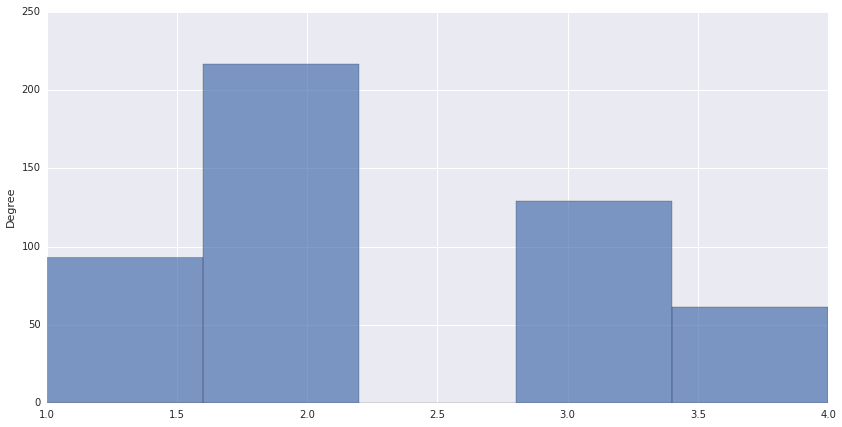

In [347]:
df = pd.read_csv(raw_data_path)

# map UPDRS ranges into 'bins' comprising a set of classificaiton labels
bins = np.linspace(df.total_UPDRS.min(), df.total_UPDRS.max(), n_stages)
df['pd_stage'] = np.digitize(df.total_UPDRS, bins)

# subsample if desired
if (subsample_n != -1):
    df = df.sample(subsample_n, axis=0)

# show a histogram representing this procedure
df['pd_stage'].plot(kind='hist',alpha=.7, figsize=(14,7), bins=n_stages)

# split X (features), y (PD stage label) from the dataframe
features = ['age', 'sex', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 
            'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 
            'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 
            'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']

X = df[features]
y = df['pd_stage']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rand_state)

# fit a standardScaler to normalize all input to zero mean and unit variance
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

#*k*-Nearest Neighbors

In [330]:
# run KNN for different values of k using CVGridSearch
knn_param_grid = [{'n_neighbors' : list(range(1,100))}]
                               
knn_gs = GridSearchCV(KNeighborsClassifier(), knn_param_grid,
                       cv=n_folds, scoring=scoring_function_label)

knn_gs.fit(X_train, y_train)

# save the best for further analysis
classifiers['KNN'] = knn_gs.best_estimator_

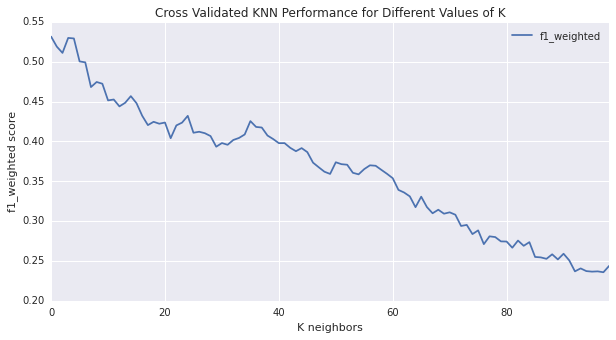

In [331]:
# plot
score_df = pd.DataFrame(knn_gs.grid_scores_, columns = ['n_neighbors', scoring_function_label, 'values'])
ax = score_df.plot(title= 'Cross Validated KNN Performance for Different Values of K', figsize=(10,5))
ax.set_xlabel("K neighbors")
ax.set_ylabel(scoring_function_label + ' score')

# Decision Trees

In [332]:
# determine optimal pruning depth for the decision trees using cross-validation grid-search on max_depth
tree_param_grid = [{'max_depth' : list(range(1, X_train.shape[1]))}]

tree_gs = GridSearchCV(DecisionTreeClassifier(random_state=rand_state),
                       tree_param_grid, cv=n_folds, scoring=scoring_function_label)

tree_gs.fit(X_train, y_train)

# save the best for further analysis
classifiers['DecisionTree'] = tree_gs.best_estimator_

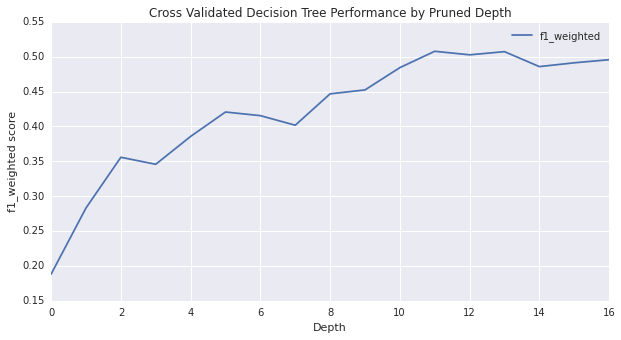

In [333]:
# plot
score_df = pd.DataFrame(tree_gs.grid_scores_, columns = ['max_depth', scoring_function_label, 'values'])
ax = score_df.plot(title= 'Cross Validated Decision Tree Performance by Pruned Depth', figsize=(10,5))
ax.set_xlabel("Depth")
ax.set_ylabel(scoring_function_label + ' score')

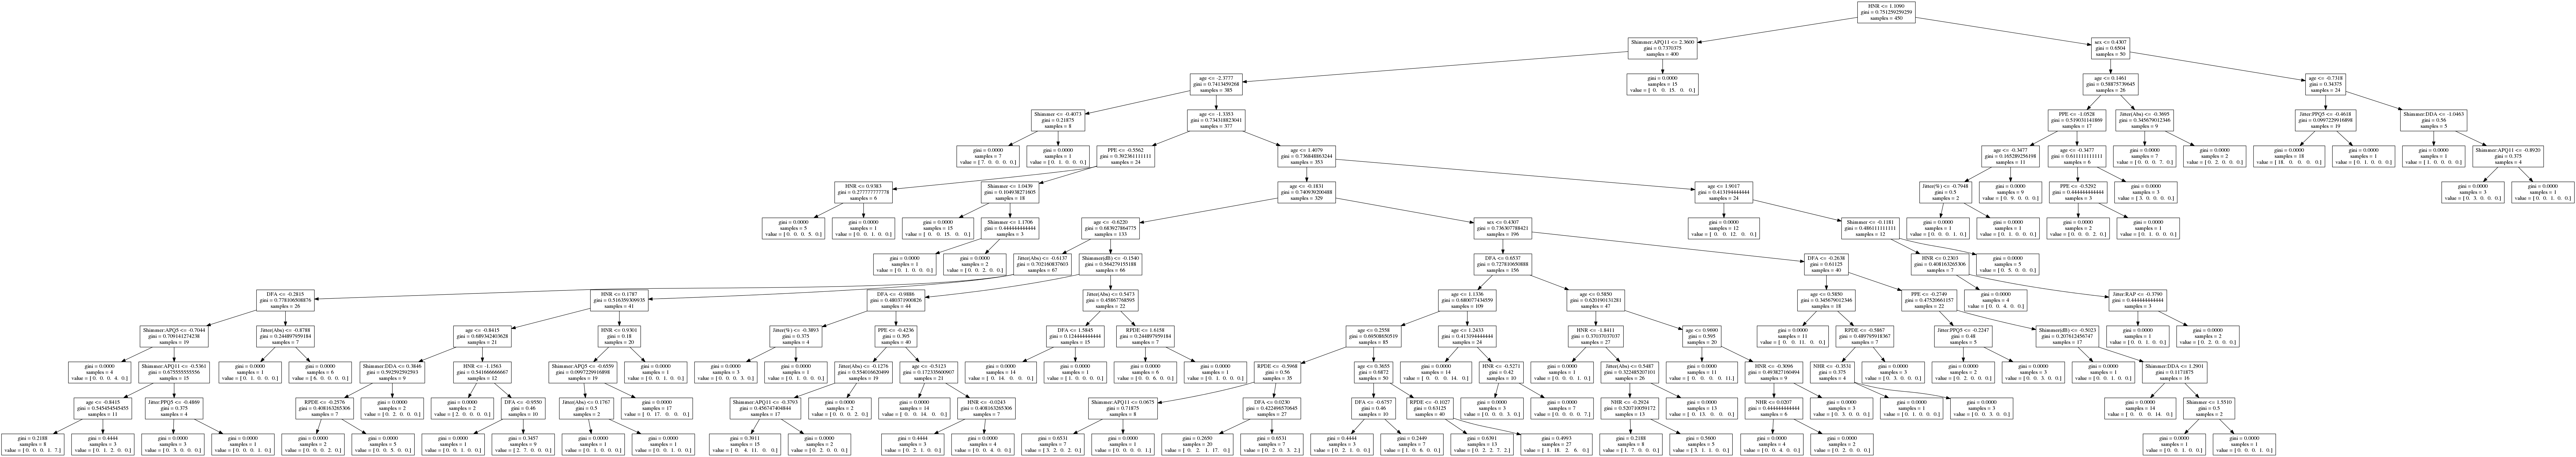

In [334]:
# visualize the optimal tree
with open('tree.dot', 'w') as dotfile:
    export_graphviz(
        classifiers['DecisionTree'],
        dotfile,
        feature_names=X_train.columns)
    
subprocess.call(['dot','-Tpng','tree.dot','-o','tree.png'])
Image(filename='tree.png')

# Boosted Trees (AdaBoost)

In [335]:
# determine optimal pruning depth for the decision trees using cross-validation grid-search on max_depth
ada_grid = [{'n_estimators' : list(range(1,100))}]

ada_gs = GridSearchCV(AdaBoostClassifier(random_state=rand_state),
                       ada_grid, cv=n_folds, scoring=scoring_function_label)

ada_gs.fit(X_train, y_train)

# save the best for further analysis
classifiers['AdaBoost'] = ada_gs.best_estimator_

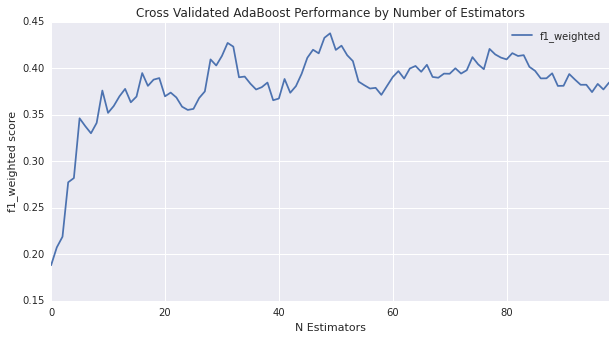

In [336]:
# plot
score_df = pd.DataFrame(ada_gs.grid_scores_, columns = ['n_estimators', scoring_function_label, 'values'])
ax = score_df.plot(title= 'Cross Validated AdaBoost Performance by Number of Estimators', figsize=(10,5))
ax.set_xlabel("N Estimators")
ax.set_ylabel(scoring_function_label + ' score')

#Support Vector Machines
##RBF Kernel

In [337]:
# run cross validation w/ grid search over SVM parameters
svm_rbf_grid = [{'gamma': np.linspace(1e-2, 1e-3,num=10), 'C': list(range(1,500,50))}]

svm_rbf_gs = GridSearchCV(SVC(random_state=rand_state, kernel='rbf'), svm_rbf_grid,
                       cv=n_folds, scoring=scoring_function_label)

svm_rbf_gs.fit(X_train, y_train)

# save the best for further analysis
classifiers['svm_rbf'] = svm_rbf_gs.best_estimator_

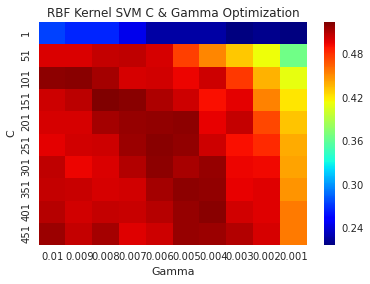

In [338]:
# plot
score_df = pd.DataFrame(columns=svm_rbf_grid[0]['gamma'], index=svm_rbf_grid[0]['C'])

for params, mean_score, scores in svm_rbf_gs.grid_scores_:
    score_df.loc[params['C']][params['gamma']] = mean_score

ax = sns.heatmap(score_df.fillna(value=0.), cmap="jet")
ax.set_title('RBF Kernel SVM C & Gamma Optimization')
ax.set_xlabel("Gamma")
ax.set_ylabel('C')

##Sigmoid Kernel

In [339]:
# run cross validation w/ grid search over SVM parameters
svm_sig_grid = [{'gamma': [round(i,5) for i in np.linspace(1e-2, 2e-3,num=10)],
                 'coef0': [round(i,5) for i in np.linspace(0.0, 0.1,num=10)]}]

svm_sig_gs = GridSearchCV(SVC(random_state=rand_state, kernel='sigmoid'), svm_sig_grid,
                       cv=n_folds, scoring=scoring_function_label)

svm_sig_gs.fit(X_train, y_train)

# save the best for further analysis
classifiers['svm_sigmoid'] = svm_sig_gs.best_estimator_

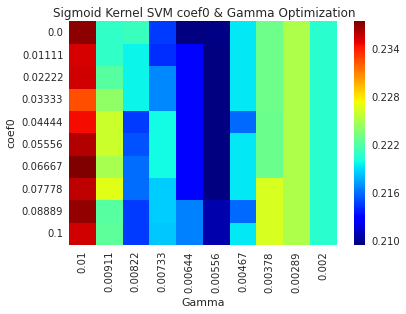

In [340]:
# plot
score_df = pd.DataFrame(columns=svm_sig_grid[0]['gamma'], index=svm_sig_grid[0]['coef0'])

for params, mean_score, scores in svm_sig_gs.grid_scores_:
    score_df.loc[params['coef0']][params['gamma']] = mean_score

ax = sns.heatmap(score_df.fillna(value=0.), cmap="jet")
ax.set_title('Sigmoid Kernel SVM coef0 & Gamma Optimization')
ax.set_xlabel("Gamma")
ax.set_ylabel('coef0')

#Artificial Neural Networks

In [341]:
# specify network layers
layers0 = [
    # input layer
    (InputLayer, {'shape': (None, X_train.shape[1])}),

    # single dense layer
    (DenseLayer, {'num_units': 100}),

    # the output layer
    (DenseLayer, {'num_units': n_stages, 'nonlinearity': softmax}),
]

nn = NeuralNet(
    layers=layers0,
    max_epochs=100,

    update=sgd,
    update_learning_rate=.01,

    train_split=TrainSplit(eval_size=0.25),
    verbose=0,
)

nn.fit(X_train.as_matrix(), y_train.as_matrix().astype('int32'))

# save the best for further analysis
classifiers['neural_network'] = nn

ValueError: y_i value out of bounds
Apply node that caused the error: CrossentropySoftmaxArgmax1HotWithBias(Dot22.0, dense2.b, y_batch)
Toposort index: 12
Inputs types: [TensorType(float64, matrix), TensorType(float64, vector), TensorType(int32, vector)]
Inputs shapes: [(128, 5), (5,), (128,)]
Inputs strides: [(40, 8), (8,), (4,)]
Inputs values: ['not shown', array([ 0.,  0.,  0.,  0.,  0.]), 'not shown']
Outputs clients: [[Sum{acc_dtype=float64}(CrossentropySoftmaxArgmax1HotWithBias.0)], [CrossentropySoftmax1HotWithBiasDx(Assert{msg='`sm` and `dy` do not have the same shape.'}.0, CrossentropySoftmaxArgmax1HotWithBias.1, y_batch)], []]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
plot_loss(nn)

# Classification Performance Over N-Samples

In [ ]:
# re-run the model with optimum k over different training set sizes & plot
# build a dataframe containing the results of these experiments
n_training = range(25,y_train.shape[0],50)

performance_columns = ['classifier', 'dataset', 'n-training_samples', scoring_function_label]
sub_sampling_performance = pd.DataFrame(columns=performance_columns)

for lbl, clf in zip(classifiers.keys(), classifiers.values()):
    training_array, testing_array = run_training_range(clf, scoring_function, n_training, 
                                                       X_train.as_matrix(), y_train.as_matrix().astype('int32'),
                                                       X_test.as_matrix(), y_test.as_matrix())
    
    training_df = pd.DataFrame(columns=performance_columns)
    training_df['n-training_samples'] = n_training
    training_df[scoring_function_label] = training_array
    training_df['classifier'] = [lbl] * len(training_df)
    training_df['dataset'] = ['train'] * len(training_df)
    
    testing_df = pd.DataFrame(columns=performance_columns)
    testing_df['n-training_samples'] = n_training
    testing_df[scoring_function_label] = testing_array
    testing_df['classifier'] = [lbl] * len(testing_df)
    testing_df['dataset'] = ['test'] * len(testing_df)
    
    sub_sampling_performance = pd.concat([sub_sampling_performance, training_df, testing_df], axis=0)

In [ ]:
g = sns.FacetGrid(sub_sampling_performance, row='classifier',
                  hue='dataset',palette="Set1", size=10, aspect=2,
                  hue_order=["test", "train"])
g = g.map(plt.plot, "n-training_samples", scoring_function_label).add_legend()

#Confusion Matricies

In [ ]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(17,10)
for i, (label, clf) in enumerate(zip(classifiers.keys(), classifiers.values())):
    cm_df = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)))
    sns.heatmap(cm_df, ax=axs.flat[i], cmap="jet")
    axs.flat[i].set_title(label)

# Classifier Performance Comparison

In [ ]:
# collect performance stats on all classifiers
performance = compare_classifiers(classifiers, scoring_function, X_test.as_matrix(), y_test.as_matrix())
performance = pd.DataFrame.from_dict(performance, orient='index')
performance.columns = [scoring_function_label]

# plot
ax = sns.barplot(x=scoring_function_label, y=performance.index.get_values(), data=performance, orient='h')
ax.set_title('Test Set Algorithm Performance')
ax.set_xlabel(scoring_function_label)

In [ ]:
print('Total runtime: ', time.time() - start)